<a href="https://colab.research.google.com/github/And2300/IA025_2022S1/blob/main/Aula_4_Exerc%C3%ADcio_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST
import math 

## Fixando as seeds

In [2]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [3]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [4]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [46]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)

In [6]:
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

In [7]:
class DataLoader:  
    def __init__(self, dataset, batch_size=batch_size, shuffle=False):
        self.dataset = list(dataset)
        self.batch_size = batch_size
        self.index = 0
        if shuffle == True:
            random.shuffle(self.dataset)

        self.data = list(zip(*self.dataset))
        self.data[0] = torch.stack(self.data[0], dim=0)
        self.data[1] = torch.tensor(self.data[1]).long()

    def __iter__(self):
        self.index = 0
        return self

    def __len__(self):
        return math.ceil(len(self.dataset)/self.batch_size)

    def __next__(self):  #code from Larissa
        if self.index < len(self):
            item1 = self.data[0][self.index*self.batch_size : self.index*self.batch_size+self.batch_size]
            item2 = self.data[1][self.index*self.batch_size : self.index*self.batch_size+self.batch_size]
            self.index += 1
            return item1, item2
        else:
            raise StopIteration

In [47]:
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)

In [48]:
print('Número de minibatches de trenamento:', len(loader_train))
x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [10]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

In [11]:
class Model():
    def __init__(self, n_in:int, n_out:int):
        self.w = torch.zeros(n_out, n_in, requires_grad=True)
        self.b = torch.zeros(n_out, requires_grad=True)
    
    def __call__(self, x):
        y_pred = x.mm(torch.t(self.w)) + self.b.unsqueeze(0)
        return y_pred

    def parameters(self):
        return self.w , self.b

## Treinamento

### Inicialização dos parâmetros

In [12]:
n_epochs = 50

## Definição da Loss

$$CE=\frac{-\Sigma (-1z_y + log(\Sigma_j e^{z_j}))}{N}$$



In [13]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()

In [14]:
def criterion(predict, targets):  #from Karen
    log_sum_1 = torch.log(torch.sum(torch.exp(predict), dim=1, keepdim=True))
    pred = predict.gather(dim=1, index= targets.unsqueeze(dim=1)).squeeze(dim=1)
    num = -pred + log_sum_1
    loss_total = torch.mean(num)
    return loss_total

# Definição do Optimizer

In [15]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)

In [16]:
class SGD():
    def __init__(self, parameters: tuple, learning_rate: float):
        self.parameters = parameters 
        self.learning_rate = learning_rate

    def step(self):
        for parameter in self.parameters:
            parameter.data -= self.learning_rate*parameter.grad

    def zero_grad(self): #zero=True
        for parameter in self.parameters:
            parameter.grad = torch.zeros_like(parameter.data)

### Laço de treinamento dos parâmetros

In [17]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
lr = 0.1
model = Model(28*28,10)
optimizer = SGD(parameters=model.parameters(), learning_rate=lr)

for i in range(n_epochs):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

Epoch: 0/49 Loss: 1.1921143531799316
Epoch: 1/49 Loss: 0.8454068303108215
Epoch: 2/49 Loss: 0.6862919926643372
Epoch: 3/49 Loss: 0.5910305976867676
Epoch: 4/49 Loss: 0.5264344215393066
Epoch: 5/49 Loss: 0.4792433977127075
Epoch: 6/49 Loss: 0.4429572820663452
Epoch: 7/49 Loss: 0.4139828681945801
Epoch: 8/49 Loss: 0.39016568660736084
Epoch: 9/49 Loss: 0.3701329231262207
Epoch: 10/49 Loss: 0.35296741127967834
Epoch: 11/49 Loss: 0.33803221583366394
Epoch: 12/49 Loss: 0.324870228767395
Epoch: 13/49 Loss: 0.3131448030471802
Epoch: 14/49 Loss: 0.3026019036769867
Epoch: 15/49 Loss: 0.29304608702659607
Epoch: 16/49 Loss: 0.2843242585659027
Epoch: 17/49 Loss: 0.2763148546218872
Epoch: 18/49 Loss: 0.2689197361469269
Epoch: 19/49 Loss: 0.26205891370773315
Epoch: 20/49 Loss: 0.25566622614860535
Epoch: 21/49 Loss: 0.249687060713768
Epoch: 22/49 Loss: 0.24407488107681274
Epoch: 23/49 Loss: 0.23879075050354004
Epoch: 24/49 Loss: 0.2338012158870697
Epoch: 25/49 Loss: 0.2290775179862976
Epoch: 26/49 Los

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

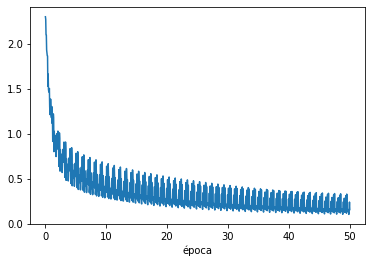

In [18]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

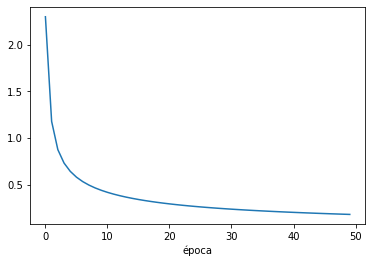

In [19]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [23]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-1)  #1e-6

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

In [ ]:
# Escreva o código aqui: #from Pedro

In [65]:
x,y, y_preds = [],[],[]
for x_train, y_train in loader_train:
  out = model(x_train.view(-1, 28*28))
  y_pred = (torch.exp(out)/torch.sum(torch.exp(out), dim=1, keepdim=True))  #softmax
  x.append(x_train)
  y.append(y_train)
  y_preds.append(y_pred)

x = torch.cat(x, 0)
y = torch.cat(y, 0)
y_pred = torch.cat(y_pred, 0)

In [66]:
correct = y == y_pred.argmax(1)
x_corrects = x[correct]
y_corrects = y[correct]
y_preds_corrects = y_pred[correct]

In [67]:
wrong = y != y_pred.argmax(1)
x_wrongs = x[wrong]
y_wrongs = y[wrong]
y_preds_wrongs = y_pred[wrong]

In [68]:
idx_hpc = y_preds_corrects.max(1).values.argmax()
idx_lpc = y_preds_corrects.max(1).values.argmin()

idx_hpw = y_preds_wrongs.max(1).values.argmax()
idx_lpw = y_preds_wrongs.max(1).values.argmin()

In [91]:
y_preds_corrects[idx_hpc].argmax().item(), y_preds_corrects[idx_hpc].max().item()

(2, 0.999992847442627)

In [70]:
y_preds_wrongs[idx_hpw].argmax().item(), y_preds_wrongs[idx_hpw].max().item()

(4, 0.9921651482582092)

In [71]:
y_preds_corrects[idx_lpc].argmax().item(), y_preds_corrects[idx_lpc].max().item()

(7, 0.281715452671051)

In [72]:
y_preds_wrongs[idx_lpw].argmax().item(), y_preds_wrongs[idx_lpw].max().item()

(9, 0.2294878512620926)

## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.
